<a href="https://colab.research.google.com/github/LinaMariaCastro/curso-ia-para-economia/blob/main/clases/5_Aprendizaje_supervisado/2_Regresion_Polinomica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial con Aplicaciones en Econom√≠a I**

- üë©‚Äçüè´ **Profesora:** [Lina Mar√≠a Castro](https://www.linkedin.com/in/lina-maria-castro)  
- üìß **Email:** [lmcastroco@gmail.com](mailto:lmcastroco@gmail.com)  
- üéì **Universidad:** Universidad Externado de Colombia - Facultad de Econom√≠a

# ‚öñÔ∏è **Regresi√≥n Polin√≥mica, Subajuste, Sobreajuste y Regularizaci√≥n**

**Objetivos de Aprendizaje**

Al finalizar este notebook, los estudiantes ser√°s capaz de:

1. **Entrenar modelos de Regresi√≥n Polin√≥mica.**
2.  **Entender los problemas de `underfitting` y `overfitting`** y el Trade-off entre Sesgo y Varianza.
3.  **Implementar la Regularizaci√≥n (Ridge y Lasso)** como una t√©cnica fundamental para controlar la complejidad del modelo y mejorar su capacidad de generalizaci√≥n.

## Importar Librer√≠as

In [1]:
# Importaci√≥n de librer√≠as est√°ndar
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Importaci√≥n de herramientas de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

## Mejorar visualizaci√≥n de dataframes y gr√°ficos

In [2]:
# Que muestre todas las columnas
pd.options.display.max_columns = None
# En los dataframes, mostrar los float con dos decimales
pd.options.display.float_format = '{:,.2f}'.format

# Configuraciones para una mejor visualizaci√≥n
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Cargar datos

In [3]:
path = r'C:\Users\Ferney Reina\Documents\Python\IA_Economia\2025-segundo-semestre-ia-economia\datasets'

In [4]:
# Para establecer el directorio de los archivos
os.chdir(path)

In [5]:
df = pd.read_csv('Salary_Data.csv')
print(df.shape)
df.head()

(6704, 6)


Age  Gender Education Level          Job Title  Years of Experience  \
0 32.00    Male      Bachelor's  Software Engineer                 5.00   
1 28.00  Female        Master's       Data Analyst                 3.00   
2 45.00    Male             PhD     Senior Manager                15.00   
3 36.00  Female      Bachelor's    Sales Associate                 7.00   
4 52.00    Male        Master's           Director                20.00   

      Salary  
0  90,000.00  
1  65,000.00  
2 150,000.00  
3  60,000.00  
4 200,000.00

## Limpieza de Datos

Inspeccionamos los tipos de datos y los valores nulos, tal como se har√≠a en un proyecto real (y como se hace en el notebook de referencia).

In [6]:
print("Informaci√≥n del DataFrame:")
df.info()

Informaci√≥n del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [7]:
print("\nValores Nulos por Columna:")
print(df.isnull().sum())


Valores Nulos por Columna:
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


In [8]:
print(df.isnull().sum()/len(df)*100)

Age                   0.03
Gender                0.03
Education Level       0.04
Job Title             0.03
Years of Experience   0.04
Salary                0.07
dtype: float64


Vemos que hay los valores nulos son muy pocos, por lo que vamos a eliminarlos, ya que esto no afectar√° significativamente al modelo.

In [9]:
# Eliminamos las filas con cualquier valor nulo
df.dropna(inplace=True)

print("Valores Nulos despu√©s de la limpieza:")
print(df.isnull().sum().sum()) # .sum().sum() da el total de nulos en todo el DataFrame

Valores Nulos despu√©s de la limpieza:
0


## Enfoque Pedag√≥gico

El dataset tiene m√∫ltiples variables (categ√≥ricas y num√©ricas). Un modelo completo requerir√≠a *One-Hot Encoding* o *Label Encoding* para `Gender`, `Education Level` y `Job Title`.

**Sin embargo, para el objetivo de *esta clase* (entender el sobreajuste visualmente),** hacer todo ese preprocesamiento introduce demasiada complejidad que distrae del punto principal.

Nos enfocaremos en la relaci√≥n econ√≥mica m√°s cl√°sica: **Teor√≠a del Capital Humano**, que postula que el salario (`Salary`) es una funci√≥n de la experiencia (`Years of Experience`). Esto nos permite modelar y visualizar el problema en 2D de forma muy clara.

## Divisi√≥n del Conjunto de Datos

Primero, seleccionamos nuestras variables `X` e `y`. Luego, dividimos los datos. **El EDA se debe hacer *despu√©s* de la divisi√≥n y *solo* sobre los datos de entrenamiento**, para evitar contaminar nuestro an√°lisis con informaci√≥n del conjunto de prueba (lo que se conoce como *data leakage* o fuga de datos).

In [10]:
# 1. Seleccionar las variables de inter√©s
X = df[['Years of Experience']]
y = df['Salary']

# 2. Dividir en conjuntos de entrenamiento y prueba (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Tama√±o del set de Entrenamiento: {X_train.shape[0]} observaciones")
print(f"Tama√±o del set de Prueba: {X_test.shape[0]} observaciones")

Tama√±o del set de Entrenamiento: 4688 observaciones
Tama√±o del set de Prueba: 2010 observaciones


In [11]:
X_train.head()

Years of Experience
4092                16.00
2180                 6.00
5224                 1.00
459                  5.00
6118                16.00

In [12]:
y_train.head()

4092   160,000.00
2180   115,000.00
5224    55,000.00
459    145,000.00
6118   215,000.00
Name: Salary, dtype: float64

## **An√°lisis Exploratorio de Datos (EDA) sobre Datos de Entrenamiento**

Ahora, exploremos *√∫nicamente* los datos de `(X_train, y_train)`.

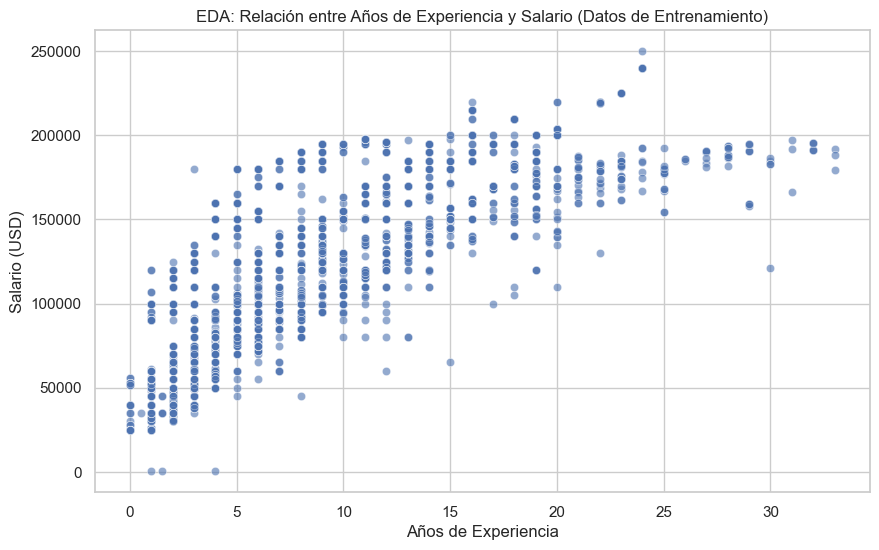

In [13]:
# 1. Relaci√≥n entre Experiencia y Salario
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train['Years of Experience'], y=y_train, alpha=0.6)
plt.title('EDA: Relaci√≥n entre A√±os de Experiencia y Salario (Datos de Entrenamiento)')
plt.xlabel('A√±os de Experiencia')
plt.ylabel('Salario (USD)')
plt.show()

**Interpretaci√≥n del EDA:**

Observamos una relaci√≥n positiva muy fuerte: a m√°s experiencia, mayor salario. Sin embargo, la nube de puntos parece curvarse ligeramente a medida que aumenta la experiencia. Esto sugiere que un modelo lineal simple (una sola recta) no es adecuado. La teor√≠a econ√≥mica (rendimientos marginales de la experiencia) apoyar√≠a la idea de que la relaci√≥n no es perfectamente lineal.

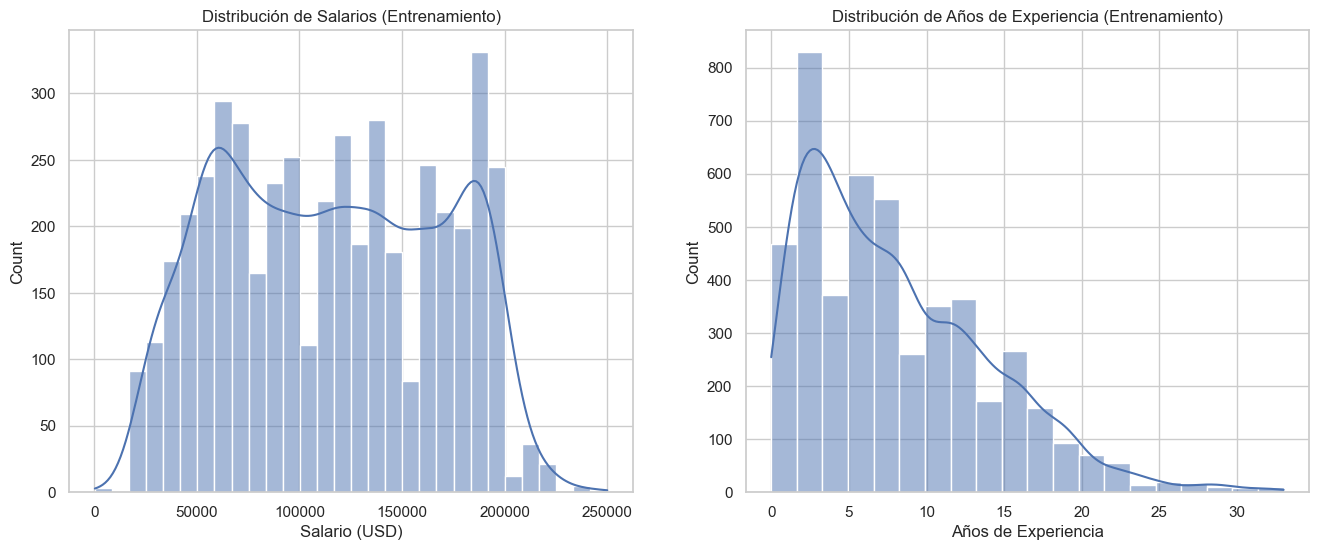

In [14]:
# 2. Distribuci√≥n de las variables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(y_train, kde=True, ax=axes[0], bins=30)
axes[0].set_title('Distribuci√≥n de Salarios (Entrenamiento)')
axes[0].set_xlabel('Salario (USD)')

sns.histplot(X_train['Years of Experience'], kde=True, ax=axes[1], bins=20)
axes[1].set_title('Distribuci√≥n de A√±os de Experiencia (Entrenamiento)')
axes[1].set_xlabel('A√±os de Experiencia')

plt.show()

## Modelo 1 - Subajuste (Underfitting)

Comencemos con el modelo m√°s simple posible: una regresi√≥n lineal simple.

In [15]:
# Creaci√≥n y entrenamiento del modelo lineal simple
model_simple = LinearRegression()
model_simple.fit(X_train, y_train)

# Predicciones
y_train_pred_simple = model_simple.predict(X_train)
y_test_pred_simple = model_simple.predict(X_test)

# C√°lculo del error (RMSE - Root Mean Squared Error)
# Usamos RMSE para que el error est√© en las mismas unidades que el salario (USD)
rmse_train_simple = np.sqrt(mean_squared_error(y_train, y_train_pred_simple))
rmse_test_simple = np.sqrt(mean_squared_error(y_test, y_test_pred_simple))

print(f"RMSE en Entrenamiento (Lineal): ${rmse_train_simple:,.2f}")
print(f"RMSE en Prueba (Lineal): ${rmse_test_simple:,.2f}")

RMSE en Entrenamiento (Lineal): $30,743.12
RMSE en Prueba (Lineal): $31,694.41


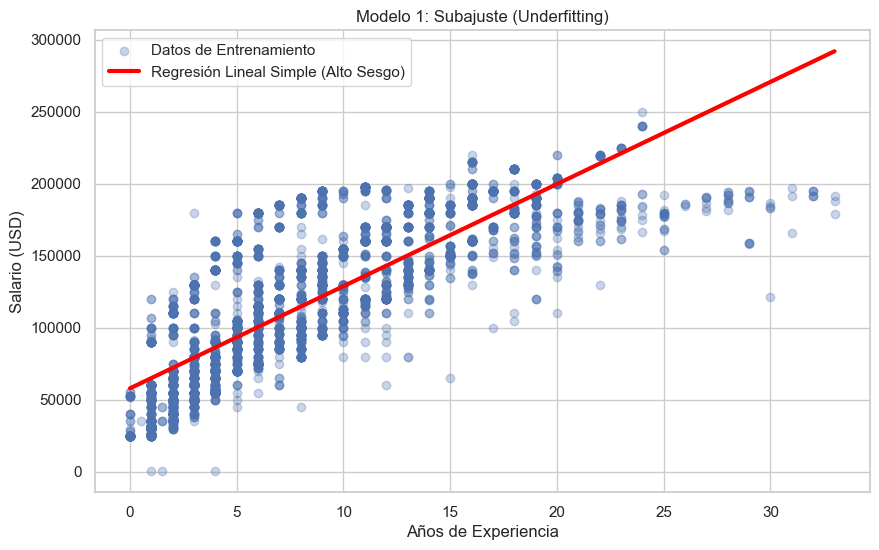

In [16]:
# Visualizaci√≥n del modelo de Subajuste

# Dibujar una l√≠nea de regresi√≥n suave y continua
# Para la l√≠nea, creamos puntos ordenados de X
X_plot = np.linspace(X_train.min(), X_train.max(), 100)
y_plot_simple = model_simple.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.3, label='Datos de Entrenamiento')
plt.plot(X_plot, y_plot_simple, color='red', linewidth=3, label='Regresi√≥n Lineal Simple (Alto Sesgo)')
plt.title('Modelo 1: Subajuste (Underfitting)')
plt.xlabel('A√±os de Experiencia')
plt.ylabel('Salario (USD)')
plt.legend()
plt.show()

**Interpretaci√≥n:**

El modelo lineal captura la tendencia general, pero podemos ver visualmente que **sobrestima** sistem√°ticamente los salarios para empleados con m√°s de 20 a√±os de experiencia.

## Modelo 2 - Sobreajuste (Overfitting)

Ahora, vamos al extremo opuesto. Crearemos un modelo extremadamente flexible (un polinomio de grado 25) que "memorizar√°" los datos.

In [17]:
# Creamos un pipeline para automatizar los pasos:
# 1. Crear caracter√≠sticas polin√≥micas de grado 25
# 2. Escalar las caracter√≠sticas (Explicado arriba)
# 3. Ajustar un modelo lineal a esas caracter√≠sticas

pipeline_poly = Pipeline([
    ("poly_features", PolynomialFeatures(degree=25, include_bias=False)),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipeline_poly.fit(X_train, y_train)

# Predicciones y error
y_train_pred_poly = pipeline_poly.predict(X_train)
y_test_pred_poly = pipeline_poly.predict(X_test)

rmse_train_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
rmse_test_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))

print(f"RMSE en Entrenamiento (Poli-25): ${rmse_train_poly:,.2f} <-- ¬°El error de entrenamiento baj√≥!")
print(f"RMSE en Prueba (Poli-25): ${rmse_test_poly:,.2f} <-- ¬°¬°El error de prueba aument√≥ considerablemente!!")

RMSE en Entrenamiento (Poli-25): $26,846.81 <-- ¬°El error de entrenamiento baj√≥!
RMSE en Prueba (Poli-25): $135,633.85 <-- ¬°¬°El error de prueba aument√≥ considerablemente!!


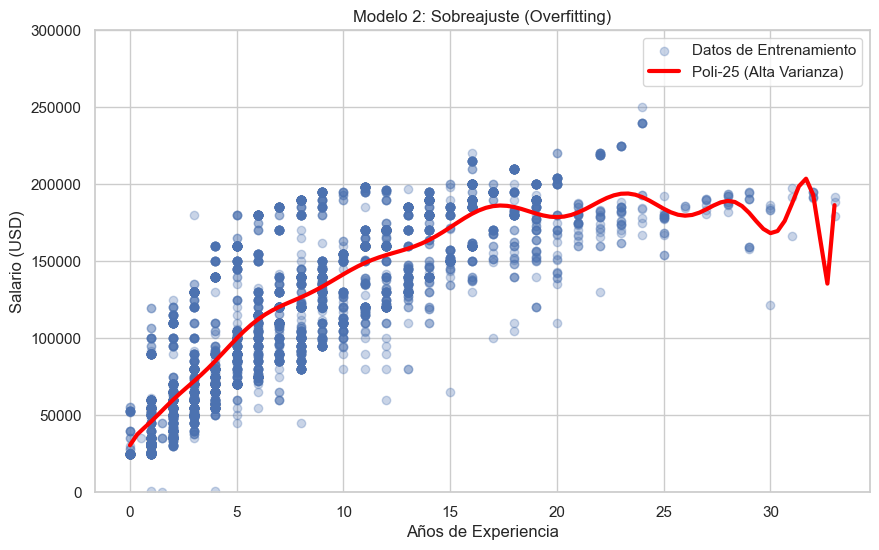

In [18]:
# Visualizaci√≥n del modelo de Sobreajuste

# Para visualizar la curva, usamos los puntos X ordenados
y_plot_poly = pipeline_poly.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.3, label='Datos de Entrenamiento')
plt.plot(X_plot, y_plot_poly, color='red', linewidth=3, label='Poli-25 (Alta Varianza)')
plt.title('Modelo 2: Sobreajuste (Overfitting)')
plt.xlabel('A√±os de Experiencia')
plt.ylabel('Salario (USD)')
plt.legend()
plt.ylim(0, 300000) # Establecemos un l√≠mite en el eje Y
plt.show()

**Interpretaci√≥n:**

¬°Miren el desastre! La curva se vuelve loca, tratando de pasar por cada punto. El RMSE de entrenamiento es m√°s bajo que el del modelo lineal (~$27.000), lo que indica que es "mejor" para describir los datos que ya vio.

Sin embargo, la curva se vuelve **err√°tica** y al enfrentarse a los datos de prueba, el error aumenta bastante (~$135.000). Este modelo **memoriz√≥ el ruido**, no el patr√≥n subyacente.

## La Soluci√≥n - Regularizaci√≥n (Ridge y Lasso)

La regularizaci√≥n es una t√©cnica que penaliza al modelo por ser demasiado complejo. Funciona modificando la "funci√≥n de costos" del modelo (la f√≥rmula que intenta minimizar).

Regresi√≥n Lineal (OLS): Su objetivo es simple, encontrar los coeficientes ($\beta$) que minimicen el Error Cuadr√°tico Medio (MSE).

Costo = Error

Regresi√≥n Lineal Regularizada: Su objetivo es un balance. Quiere minimizar el error, pero tambi√©n quiere minimizar la complejidad. Para ello, le a√±adimos un "impuesto a la complejidad".

Costo = Error + Penalizaci√≥n

El modelo ahora tiene que justificar cada coeficiente. Un coeficiente solo puede ser grande si logra una reducci√≥n importante en el MSE que "pague" el costo de su propia penalizaci√≥n.

Hay dos tipos principales de penalizaci√≥n que dan lugar a dos modelos: Ridge (L2) y Lasso (L1).

1. **Regresi√≥n Ridge (Penalizaci√≥n L2)**

La Regresi√≥n Ridge suaviza los coeficientes ($\beta$).

- *C√≥mo funciona:*

A√±ade una penalizaci√≥n proporcional al cuadrado de la magnitud de cada coeficiente.

Penalizaci√≥n Ridge (L2) = Œ± * Œ£(Œ≤¬≤)

- *El Resultado:*

La penalizaci√≥n al cuadrado castiga de forma exponencial los coeficientes muy grandes. Si un coeficiente ($\beta$) intenta crecer de 5 a 10:El error (MSE) puede bajar un poco, pero su penalizaci√≥n sube de $5^2=25$ a $10^2=100$.

El modelo r√°pidamente aprende que "no vale la pena" tener coeficientes tan grandes y los encoge a todos para encontrar un balance.

- *Efecto Clave:*

Ridge hace que los coeficientes sean peque√±os. Simplemente los suaviza, "domando" la curva err√°tica que vimos. Es √∫til si hay problemas de multicolinealidad, puesto que Ridge tiende a encoger los coeficientes de todas las variables correlacionadas de manera similar, repartiendo su efecto.

2. **Regresi√≥n Lasso (Penalizaci√≥n L1)**

Lasso es un "selector de variables".

- *C√≥mo funciona:*

A√±ade una penalizaci√≥n proporcional al valor absoluto de cada coeficiente.

Penalizaci√≥n Lasso (L1) = Œ± * Œ£(|Œ≤|)

- *El Resultado:*

La penalizaci√≥n por el valor absoluto tiene una propiedad matem√°tica asombrosa. A medida que aumenta la fuerza de la penalizaci√≥n (alpha), el modelo descubre que la mejor manera de minimizar el costo total es eliminar por completo los coeficientes de las variables menos importantes, llev√°ndolos exactamente a cero.

- *Efecto Clave:*

Lasso realiza una selecci√≥n autom√°tica de variables. Le das 25 caracter√≠sticas polin√≥micas (ruidosas) y te dice: "He analizado todas, y la verdad es que 20 de ellas son in√∫tiles (cero), as√≠ que me quedo solo con las 5 que realmente importan".

Algoritmos donde se utilizan Ridge (L2) y Lasso (L1):
- Regresi√≥n lineal
- Regresi√≥n polin√≥mica
- Regresi√≥n Log√≠stica
- Redes neuronales
- M√°quinas de Soporte Vectorial (SVM)

**¬øC√≥mo determino el valor de alpha al aplicar Ridge y Lasso?**

No hay una regla que seguir, ni se debe adivinar. Para encontrar el alpha √≥ptimo se usan t√©cnicas como la Validaci√≥n Cruzada (Cross-Validation), que veremos m√°s adelante, para probar un rango de valores (ej. 0.1, 1, 10, 100, 1000) y encontrar el alpha que da el menor error en datos de prueba.

**¬øPor qu√© Estandarizar (`StandardScaler`) al utilizar Ridge y Lasso?**

Al utilizar `PolynomialFeatures(degree=25)` se crean nuevas variables: `Experiencia^2`, `Experiencia^3`, `Experiencia^4`, ... `Experiencia^25`.

Pensemos en un empleado con 10 a√±os de experiencia:
* `Experiencia` = 10
* `Experiencia^2` = 100
* `Experiencia^15` = 10,000,000,000,000,000,000,000,000

Las escalas de nuestras variables son **dr√°sticamente diferentes**. Un modelo de regresi√≥n (incluyendo Ridge y Lasso) penaliza la **magnitud de los coeficientes**.

Si no estandarizamos, el modelo penalizar√° injustamente a las variables de menor grado (como `Experiencia`) y tendr√° problemas num√©ricos con las de grado alto.

**Recomendaci√≥n: Siempre que uses regularizaci√≥n o caracter√≠sticas polin√≥micas, DEBES estandarizar (escalar) tus datos primero.**

Ahora vamos a "curar" el sobreajuste. Usaremos el mismo modelo polin√≥mico de grado 25, pero cambiaremos `LinearRegression` por `Ridge` y `Lasso`.

## Modelo 3: Regresi√≥n Ridge (Penalizaci√≥n L2)

Ridge (L2) a√±ade una penalizaci√≥n por los coeficientes *al cuadrado*. "Encoge" los coeficientes de las variables ruidosas, pero no los lleva a cero.

In [19]:
# Creamos un pipeline con Regresi√≥n Ridge
# alpha es la fuerza de la penalizaci√≥n. Empecemos con un valor de 10.

pipeline_ridge = Pipeline([
    ("poly_features", PolynomialFeatures(degree=25, include_bias=False)),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=10))
])

pipeline_ridge.fit(X_train, y_train)

# Predicciones y error
y_train_pred_ridge = pipeline_ridge.predict(X_train)
y_test_pred_ridge = pipeline_ridge.predict(X_test)

rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

print(f"RMSE Entrenamiento (Ridge): ${rmse_train_ridge:,.2f}")
print(f"RMSE Prueba (Poli-25): ${rmse_test_poly:,.2f} (El modelo sobreajustado)")
print(f"RMSE Prueba (Ridge): ${rmse_test_ridge:,.2f} <-- ¬°¬°Gran mejora!!")

RMSE Entrenamiento (Ridge): $27,052.09
RMSE Prueba (Poli-25): $135,633.85 (El modelo sobreajustado)
RMSE Prueba (Ridge): $27,462.71 <-- ¬°¬°Gran mejora!!


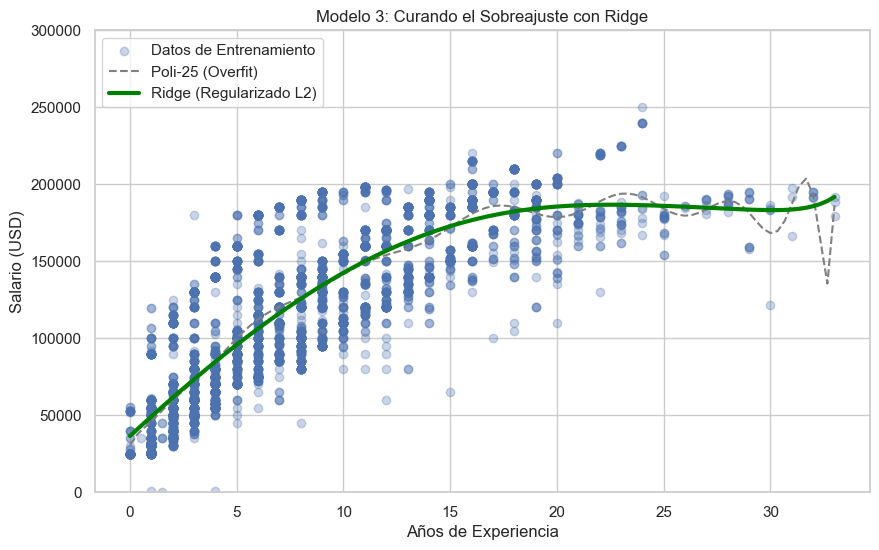

In [20]:
# Visualizaci√≥n del modelo Ridge
y_plot_ridge = pipeline_ridge.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.3, label='Datos de Entrenamiento')
plt.plot(X_plot, y_plot_poly, color='gray', linestyle='--', label='Poli-25 (Overfit)')
plt.plot(X_plot, y_plot_ridge, color='green', linewidth=3, label='Ridge (Regularizado L2)')
plt.title('Modelo 3: Curando el Sobreajuste con Ridge')
plt.xlabel('A√±os de Experiencia')
plt.ylabel('Salario (USD)')
plt.legend()
plt.ylim(0, 300000)
plt.show()

**Interpretaci√≥n:** ¬°Miren la diferencia! La curva de Ridge (verde) es **flexible** (captura la no linealidad mejor que la recta) pero **suave** y **cre√≠ble**.

La penalizaci√≥n L2 "dom√≥" la complejidad. El RMSE de entrenamiento subi√≥ un poco (lo cual es bueno, dej√≥ de memorizar), pero el RMSE de prueba **baj√≥ dr√°sticamente**. El modelo ahora generaliza.

## Modelo 4: Regresi√≥n Lasso (Penalizaci√≥n L1) y Selecci√≥n de Variables

Lasso (L1) a√±ade una penalizaci√≥n por el *valor absoluto* de los coeficientes. Su superpoder es que puede llevar coeficientes irrelevantes **exactamente a cero**.

In [21]:
# Creamos un pipeline con Regresi√≥n Lasso
# Los salarios son n√∫meros grandes, por lo que el error es grande. Necesitamos un alpha grande.
# Probemos con alpha=500. Aumentamos max_iter para asegurar que converja.

pipeline_lasso = Pipeline([
    ("poly_features", PolynomialFeatures(degree=25, include_bias=False)),
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=500, max_iter=10000))
])

pipeline_lasso.fit(X_train, y_train)

# Predicciones y error
y_train_pred_lasso = pipeline_lasso.predict(X_train)
y_test_pred_lasso = pipeline_lasso.predict(X_test)

rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))

print(f"RMSE Entrenamiento (Lasso): ${rmse_train_lasso:,.2f}")
print(f"RMSE Prueba (Ridge): ${rmse_test_ridge:,.2f} <-- ¬°El mejor resultado hasta ahora!")
print(f"RMSE Prueba (Lasso): ${rmse_test_lasso:,.2f}")

RMSE Entrenamiento (Lasso): $27,390.74
RMSE Prueba (Ridge): $27,462.71 <-- ¬°El mejor resultado hasta ahora!
RMSE Prueba (Lasso): $27,885.36


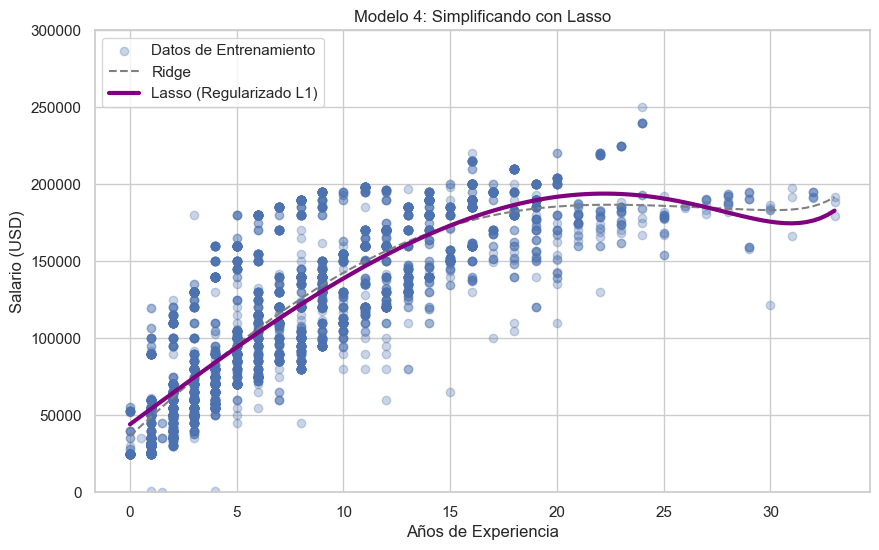

In [22]:
# Visualizaci√≥n del modelo Lasso
y_plot_lasso = pipeline_lasso.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.3, label='Datos de Entrenamiento')
plt.plot(X_plot, y_plot_ridge, color='gray', linestyle='--', label='Ridge')
plt.plot(X_plot, y_plot_lasso, color='purple', linewidth=3, label='Lasso (Regularizado L1)')
plt.title('Modelo 4: Simplificando con Lasso')
plt.xlabel('A√±os de Experiencia')
plt.ylabel('Salario (USD)')
plt.legend()
plt.ylim(0, 300000)
plt.show()

### La Magia de Lasso: Selecci√≥n de Variables

Veamos los coeficientes que Lasso ha aprendido. Recuerden que partimos de un modelo con 25 caracter√≠sticas (`Exp^1`, `Exp^2`, ..., `Exp^25`).

In [23]:
# Extraemos los coeficientes del modelo Lasso en el pipeline
coefs_lasso = pipeline_lasso.named_steps['model'].coef_

num_total_coeffs = len(coefs_lasso)
num_zero_coeffs = np.sum(coefs_lasso == 0)

print(f"N√∫mero total de coeficientes (caracter√≠sticas polin√≥micas): {num_total_coeffs}")
print(f"N√∫mero de coeficientes llevados a CERO por Lasso: {num_zero_coeffs}")
print(f"N√∫mero de coeficientes CONSERVADOS: {num_total_coeffs - num_zero_coeffs}")

print("\n--- Valor de los Coeficientes ---")
print(coefs_lasso)

N√∫mero total de coeficientes (caracter√≠sticas polin√≥micas): 25
N√∫mero de coeficientes llevados a CERO por Lasso: 20
N√∫mero de coeficientes CONSERVADOS: 5

--- Valor de los Coeficientes ---
[ 61144.71822362     -0.         -23823.84933956     -0.
     -0.              0.              0.              0.
      0.              0.              0.              0.
   1002.31431869    762.82865191    294.35327078      0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.        ]


**Interpretaci√≥n:**

¬°Este es el resultado clave! De las 25 caracter√≠sticas polin√≥micas que le dimos, Lasso decidi√≥ que muchas (ej. 20 de 25) eran "ruido" y las **elimin√≥ por completo** (llevando sus coeficientes a cero).

Actu√≥ como un **m√©todo autom√°tico de selecci√≥n de variables**, d√°ndonos un modelo m√°s simple e interpretable (m√°s **parsimonioso**) y con mejor rendimiento predictivo.

## Conclusiones y Resumen Comparativo

Pongamos todos nuestros resultados en una tabla para ver la historia completa.

In [24]:
# Creando un DataFrame para comparar los errores (RMSE)
results = pd.DataFrame({
    'Modelo': [
        '1. Lineal Simple (Subajuste)',
        '2. Polin√≥mico Grado 25 (Sobreajuste)',
        '3. Ridge (Regularizado L2)',
        '4. Lasso (Regularizado L1)'
    ],
    'RMSE en Entrenamiento': [
        rmse_train_simple,
        rmse_train_poly,
        rmse_train_ridge,
        rmse_train_lasso
    ],
    'RMSE en Prueba': [
        rmse_test_simple,
        rmse_test_poly,
        rmse_test_ridge,
        rmse_test_lasso
    ]
})

results_sorted = results.sort_values(by='RMSE en Prueba')

print("Tabla Comparativa de Rendimiento (Error en D√≥lares)")
display(results_sorted.style.format({
    'RMSE en Entrenamiento': '${:,.2f}',
    'RMSE en Prueba': '${:,.2f}'
}).background_gradient(cmap='Reds', subset=['RMSE en Prueba']))

Tabla Comparativa de Rendimiento (Error en D√≥lares)


1.  **Subajuste (Modelo 1):** Es demasiado simple. Falla en capturar el patr√≥n y tiene un error mediocre tanto en entrenamiento como en prueba (RMSE ~$31.000).
2.  **Sobreajuste (Modelo 2):** Es demasiado complejo. "Memoriza" el ruido de los datos de entrenamiento (RMSE de entrenamiento bajo) pero es in√∫til para predecir nuevos datos (RMSE de prueba explota).
3.  **Regularizaci√≥n (Modelos 3 y 4):** Son el "punto √≥ptimo". Permiten usar un modelo flexible (polin√≥mico) pero controlan su complejidad, previniendo el sobreajuste.

El modelo **Ridge** fue el m√°s preciso para predecir salarios para nuevas observaciones (el menor RMSE de prueba), por tanto, es el modelo que deber√≠amos elegir.

**Conclusi√≥n Final:**

Partimos de un modelo demasiado simple (subajuste) y luego creamos uno deliberadamente complejo que se sobreajust√≥ al ruido. La regularizaci√≥n, tanto Ridge como Lasso, nos permiti√≥ "curar" este sobreajuste, controlando la complejidad y mejorando dr√°sticamente la capacidad del modelo para generalizar a nuevos datos. Lasso, en particular, nos dio el beneficio adicional de simplificar el modelo al realizar una selecci√≥n autom√°tica de variables.

El dilema entre overfitting y underfitting es el n√∫cleo del machine learning aplicado. **Nuestro trabajo no es minimizar el error en los datos que ya tenemos, sino construir modelos que sean robustos y fiables para el futuro.**